In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path 
import re 
import scipy.stats as stats

In [2]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_2")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [3]:
ls texture_mono_eval

word_task_half_co_loc_v07/
word_task_half_co_loc_v08_gender_bal_4M_orig/
word_task_half_co_loc_v08_gender_bal_4M_w_no_cue_learned/
word_task_half_co_loc_v08_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout/
word_task_standard_v08/
word_task_v10_backbone_word_config_w_babble/
word_task_v10_main_feature_gain_config/


In [4]:
texture_manifest  = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/synthetic_textures/manifest.pdpkl')


In [5]:
texture_manifest.head()

,channels,clip_dur_in_s,clip_end_in_s,clip_start_in_s,index_example,index_texture,label,sr,src_fn,src_fn_original,total_file_duration_in_s
0,0,5.0,5.0,0,0,0,16mm_projector,44100,/om2/user/msaddler/spatial_audio_pipeline/asse...,/scratch2/scratch/Wed/salavill/training_sounds...,5.0
1,0,5.0,5.0,0,1,0,16mm_projector,44100,/om2/user/msaddler/spatial_audio_pipeline/asse...,/scratch2/scratch/Wed/salavill/training_sounds...,5.0
2,0,5.0,5.0,0,2,0,16mm_projector,44100,/om2/user/msaddler/spatial_audio_pipeline/asse...,/scratch2/scratch/Wed/salavill/training_sounds...,5.0
3,0,5.0,5.0,0,3,0,16mm_projector,44100,/om2/user/msaddler/spatial_audio_pipeline/asse...,/scratch2/scratch/Wed/salavill/training_sounds...,5.0
4,0,5.0,5.0,0,4,0,16mm_projector,44100,/om2/user/msaddler/spatial_audio_pipeline/asse...,/scratch2/scratch/Wed/salavill/training_sounds...,5.0


In [6]:
# get unique index_texure and labels 

texture_ix_map = {item.index_texture:item.label for item in texture_manifest[['index_texture', 'label']].drop_duplicates().itertuples()}
# texture_ix_map

In [7]:
# Path to results 
# output_paths = list(Path("binaural_eval/word_task_voice_loc_cue_only_v04").glob("*.pkl")) old path for more locations
# match human pilot conditions
# model_name = 'word_task_half_co_loc_v06'
output_paths = list(Path(f"texture_mono_eval/").glob("*/*.csv"))


results_dfs = []

for path in output_paths:
    # if any([string in path.stem for string in ['v06', 'more', 'old']]):
    #     continue
    # res_dict = pickle.load(open(path, 'rb'))
    if 'v10' not in path.stem:
        continue
    try:
        df = pd.read_csv(path)
    except Exception as e:
        print(path.stem, e)
        continue 
    if 'word_task_v10_main_feature_gain_config' in str(path):
        print('here')
    model_name = path.parent.stem
    print(model_name)
    df['model'] = model_name
    # merge with stim manifest
   
    snr = int(re.search('(-?\d+)dB_SNR', path.stem).group(0).strip('dB_SNR'))
    df['snr'] = snr
    results_dfs.append(df)
results = pd.concat(results_dfs)
results['texture_label'] = results['texture_int'].map(texture_ix_map)

word_task_v10_backbone_word_config_w_babble
here
word_task_v10_main_feature_gain_config
here
word_task_v10_main_feature_gain_config
here
word_task_v10_main_feature_gain_config


In [8]:
results.model.unique()

array(['word_task_v10_backbone_word_config_w_babble',
       'word_task_v10_main_feature_gain_config'], dtype=object)

In [9]:
results.snr.unique()

array([-3])

In [10]:
grouped_results = results.groupby(['model', 'texture_label', 'snr']).agg({'accuracy':['mean', 'sem']}).reset_index()
# flatten multiindex
grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]
# remove trailing underscore
grouped_results.columns = [col[:-1] if col[-1] == '_' else col for col in grouped_results.columns.values]


# # grouped_results["elevation_cond"] = grouped_results.apply(lambda row: f"target {row.target_elev} distractor {row.distractor_elev}", axis=1)
# grouped_results['elevation_sep'] = grouped_results.target_elev - grouped_results.distractor_elev
# grouped_results['abs_elevation_sep'] = grouped_results.elevation_sep.abs()
# grouped_results['elevated_source'] = grouped_results.elevation_sep.apply(lambda x: 'target' if x > 0 else 'distractor' if x < 0 else 'co-located') 

# grouped_results['abs_target_azim'] = grouped_results.target_azim.abs()
# grouped_results['abs_distractor_azim'] = grouped_results.distractor_azim.abs()

# grouped_results['azim_delta'] = grouped_results.target_azim - grouped_results.distractor_azim
# grouped_results['abs_azim_delta'] = (grouped_results.target_azim - grouped_results.distractor_azim).abs()




In [11]:
### Get human data 

# human_df = pd.read_pickle('/om2/user/msaddler/tfauditoryutil/saved_models/HUMAN/spkr_word/human_data_saddler_2023_speech_in_synthetic_textures.pkl')
human_df = pd.read_pickle('/om2/user/msaddler/tfauditoryutil/backup_human_data/spkr_word/human_data_saddler_2023_speech_in_synthetic_textures.pkl')

In [12]:
human_df.head()

,index_texture,snr,correct_word,fn_eval,tag_expt,tag_model
0,0.0,-3.0,0.444444,566a4cf27da0350012b4582d,speech_in_synthetic_textures,human
1,1.0,-3.0,0.555556,566a4cf27da0350012b4582d,speech_in_synthetic_textures,human
2,2.0,-3.0,1.000000,566a4cf27da0350012b4582d,speech_in_synthetic_textures,human
3,3.0,-3.0,0.625000,566a4cf27da0350012b4582d,speech_in_synthetic_textures,human
4,4.0,-3.0,0.444444,566a4cf27da0350012b4582d,speech_in_synthetic_textures,human


In [13]:
human_df['texture_label'] = human_df['index_texture'].map(texture_ix_map)

In [14]:
# rename human_df columns to match results
human_df = human_df.rename(columns={'correct_word': 'accuracy', 'tag_model': 'model'})

In [15]:
# merege human and model data
all_results = pd.concat([results[results.snr == -3], human_df])
# rename models and human 
# all_results['model'] = all_results['model'].replace({'human': 'Participants', 'word_task_half_co_loc_v07': 'v07 Model'})
all_results['model'] = all_results['model'].replace({'human': 'Participants'})

In [16]:
all_results.model.unique()

array(['word_task_v10_backbone_word_config_w_babble',
       'word_task_v10_main_feature_gain_config', 'Participants'],
      dtype=object)

Feature-gain Model
Participants


Text(0.5, 1.0, 'Speech in textures - Model vs Participants')

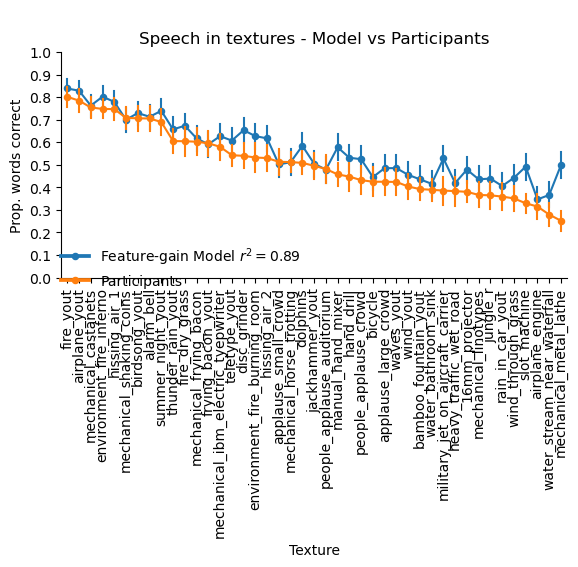

In [17]:
### Compare humans to models 


# order by human accuracy
texture_order = all_results[all_results.model == 'Participants'].groupby('texture_label')['accuracy'].mean().sort_values(ascending=False).index

to_plot = all_results[all_results.model.isin(['Participants', 'word_task_v10_main_feature_gain_config'])]
to_plot.loc[to_plot.model == "word_task_v10_main_feature_gain_config", "model" ] = 'Feature-gain Model'

g = sns.catplot(data=to_plot, x='texture_label', y='accuracy', kind='point', order=texture_order,
                hue='model',
                height=3, aspect=2,  errorbar=('se',2), markers='.', linestyles='-')

model_legend_strs = []
for ix, model in enumerate(to_plot.model.unique()):
    print(model)
    if model == 'Participants':
        continue
    model_perf = to_plot[to_plot.model == model].groupby('texture_label')['accuracy'].mean()
    human_perf = to_plot[to_plot.model == 'Participants'].groupby('texture_label')['accuracy'].mean()
    r, p = stats.pearsonr(model_perf, human_perf)
    model_str = f"{model} $r^2={r**2:.2f}$"
    model_legend_strs.append(model_str)
    # change string in legend for this model
    g._legend.texts[ix].set_text(model_str)
    # 

# put legend in lower left
g._legend.set_bbox_to_anchor((0.4, 1))
g._legend.set_title('')


# g.axes[0,0].legend(handles=bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
# change line thickness
for line in g.ax.lines:
    line.set_linewidth(1.5)

g.set(yticks=np.arange(0,  1.1, 0.1))
g.set_xticklabels(rotation=90)
g.set_axis_labels("Texture", "Prop. words correct")
plt.title("Speech in textures - Model vs Participants")

# update legend 

# get pearson correlation between model and human and add to plot
    # plt.text(0.5, 0.98 - ix * .08, f"{model} r={r:.2f}", ha='center', va='center', transform=g.ax.transAxes, fontsize=8)


# Correlation scatter plots

Each cell is a different model.

In [18]:
## Compute noise corrected accuracy
# First compute 10,000 split half reliabilities for human data and model data separately    
# Then compute spearman brown correction using averaged reliability  
from tqdm import tqdm

np.random.seed(0)


# split half reliability
def split_half_reliability(data, n_splits=10000):
    reliabilities = np.zeros(n_splits)
    for i in tqdm(range(n_splits)):
        split1 = data.sample(frac=0.5)
        split2 = data.drop(split1.index)
        split1 = split1.groupby('texture_label')['accuracy'].mean().values
        split2 = split2.groupby('texture_label')['accuracy'].mean().values
        r, p = stats.pearsonr(split1, split2)
        reliabilities[i] = r
    mean_r = np.mean(reliabilities)
    split_half_r = (2*mean_r) / (1 + mean_r)
    return split_half_r, reliabilities

hunan_rho, human_reliabilities = split_half_reliability(human_df, n_splits=10000)

model_results_for_comp = results[(results.snr == -3) & (results.model == 'word_task_v10_main_feature_gain_config')]
model_rho, model_reliabilities = split_half_reliability(model_results_for_comp, n_splits=10000)

# means_1 = human_df.groupby('texture_label')['accuracy'].agg(['mean', 'sem'])['mean'].values

human_perf = human_df.groupby('texture_label')['accuracy'].agg(['mean', 'sem']).reset_index()
model_perf = model_results_for_comp.groupby('texture_label')['accuracy'].agg(['mean', 'sem']).reset_index()
r_model_human, p = stats.pearsonr(model_perf['mean'].values, human_perf['mean'].values)

# spearman brown correction
spearman_brown_r = r_model_human / np.sqrt(hunan_rho * model_rho)




  1%|          | 109/10000 [00:00<00:27, 358.21it/s]

100%|██████████| 10000/10000 [02:22<00:00, 70.14it/s]


Text(0.5, 1.05, 'Experiment 2: Speech in textures')

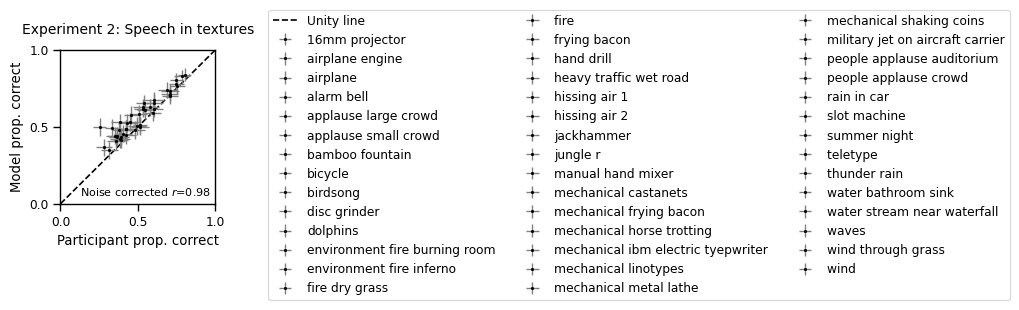

In [36]:
# sns.set_context('paper')
# plot human performance against model performance
fig, axs =  plt.subplots(1,1, figsize=(2,2))
fontsize=10
# make  palette for texture labels
palette = sns.color_palette("husl", len(human_perf))
to_plot = human_perf.copy()
to_plot['texture_label'] = [label.replace('_', ' ').replace('yout', '') for label in to_plot['texture_label']]

x = y = np.linspace(0,1,5)

# plot data with 2 sem error bars
axs.plot(x,y, ls='dashed', color='k', label='Unity line')

for i, row in to_plot.iterrows():
    axs.errorbar(x=row['mean'], y=model_perf.iloc[i]['mean'],
              xerr = row['sem']*2, yerr=model_perf.iloc[i]['sem']*2, fmt='.', 
              label=row['texture_label'],
            #   marker_facecolor='k',
              color='k',
              ecolor='grey', #  palette[i]
              lw=1,
              markersize=2.5,
              alpha=1,
              )

axs.set_xlabel('Participant prop. correct')
axs.set_ylabel('Model prop. correct')

# add correlation as text
axs.annotate(f"Noise corrected $r$={spearman_brown_r:.2f}", (0.125, 0.05), fontsize=fontsize-2)
axs.set_ylim(0,1)
# set yticks to 0 .5 and 1 
axs.set_yticks(np.arange(0, 1.1, 0.5))
axs.set_xticks(np.arange(0, 1.1, 0.5))
axs.set_xlim(0,1)
# axs.yaxis.set_major_locator(plt.MaxNLocator(3))

# add legend
axs.legend( loc='upper left', ncol=3, bbox_to_anchor=(1.3,1.3))
plt.title("Experiment 2: Speech in textures", fontsize=fontsize, y=1.05) 

# plt.savefig(fig_out_dir / "human_model_texture_comparison_no_color.pdf", bbox_inches='tight', transparent=True)